## This notebook produces a single image if you enter RA and DEC

In [1]:
import numpy
import lsst.daf.butler as dafButler
# What version of the LSST Science Pipelnes are we using?
! echo $IMAGE_DESCRIPTION
! eups list -s | grep lsst_distrib

import pandas
pandas.set_option('display.max_rows', 1000)

# allow for matplotlib to create inline plots in our notebook
%matplotlib inline
import matplotlib.pyplot as plt      # imports matplotlib.pyplot as plt
import warnings                      # imports the warnings library

from astropy.wcs import WCS          # imports astropy's World Coordinate System function WCS

from IPython.display import Markdown as md

# from rubin_jupyter_utils.lab.notebook import get_catalog, retrieve_query    
from rubin_jupyter_utils.lab.notebook import get_tap_service, retrieve_query    

import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib') 

repo = 's3://butler-us-central1-dp01'  
collection='2.2i/runs/DP0.1'
#collection='1.2i/runs/DP0.1'

from lsst.rsp import get_tap_service, retrieve_query

# Deprecated
# service = get_catalog()
butler = dafButler.Butler(repo,collections=collection)
import lsst.geom as geom
from lsst.afw.image import MultibandExposure
from astropy.visualization import make_lupton_rgb

Recommended (Weekly 2023_21)
lsst_distrib          gdf42428520+d521942ec3 	current w_2023_21 setup


## Put RA and DEC here:

In [2]:
ra = 59.65688129 
dec = -36.75083078
filter_id = 'r'

## This will produce the output image

This uses the input RA and DEC to find the tract and patch where that location is found.

In [3]:
import lsst.geom
#my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees, -32.269167*lsst.geom.degrees)
my_spherePoint = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
#print(my_spherePoint)

skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
tract1 = str(my_tract)
tract2 = str(my_patch_id)
tract1_ok = tract1[13:17]
#print(tract1_ok)

#dataId = """{'band': """+"""'"""+filter_id+"""','tract': """+tract1_ok+""", 'patch':"""+tract2+"""}"""

#dataId1 = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(tract2)}
dataId_g = {'band': 'g', 'tract': int(tract1_ok), 'patch':int(tract2)}
dataId_r = {'band': 'r', 'tract': int(tract1_ok), 'patch':int(tract2)}
dataId_i = {'band': 'i', 'tract': int(tract1_ok), 'patch':int(tract2)}


#dataId2 = {'band': filter_id, 'tract': int(tract1_ok), 'patch':int(tract2), 'detector':76, 'visit':512055}


#print('my_tract = ', my_tract)
#print('my_patch = ', my_patch)
#print('my_patch_id = ',my_patch_id)
#print("For RA of "+str(ra)+" and DEC of "+str(dec)+", tract =",dataId['tract'], " and patch =", dataId['patch'])

In [52]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [56]:
def create_rgb(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

In [58]:
cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                              datasetType='deepCoadd', cutoutSideLength=701)
cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                              datasetType='deepCoadd', cutoutSideLength=701)
cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                              datasetType='deepCoadd', cutoutSideLength=701)
coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)



NameError: name 'create_rgb' is not defined

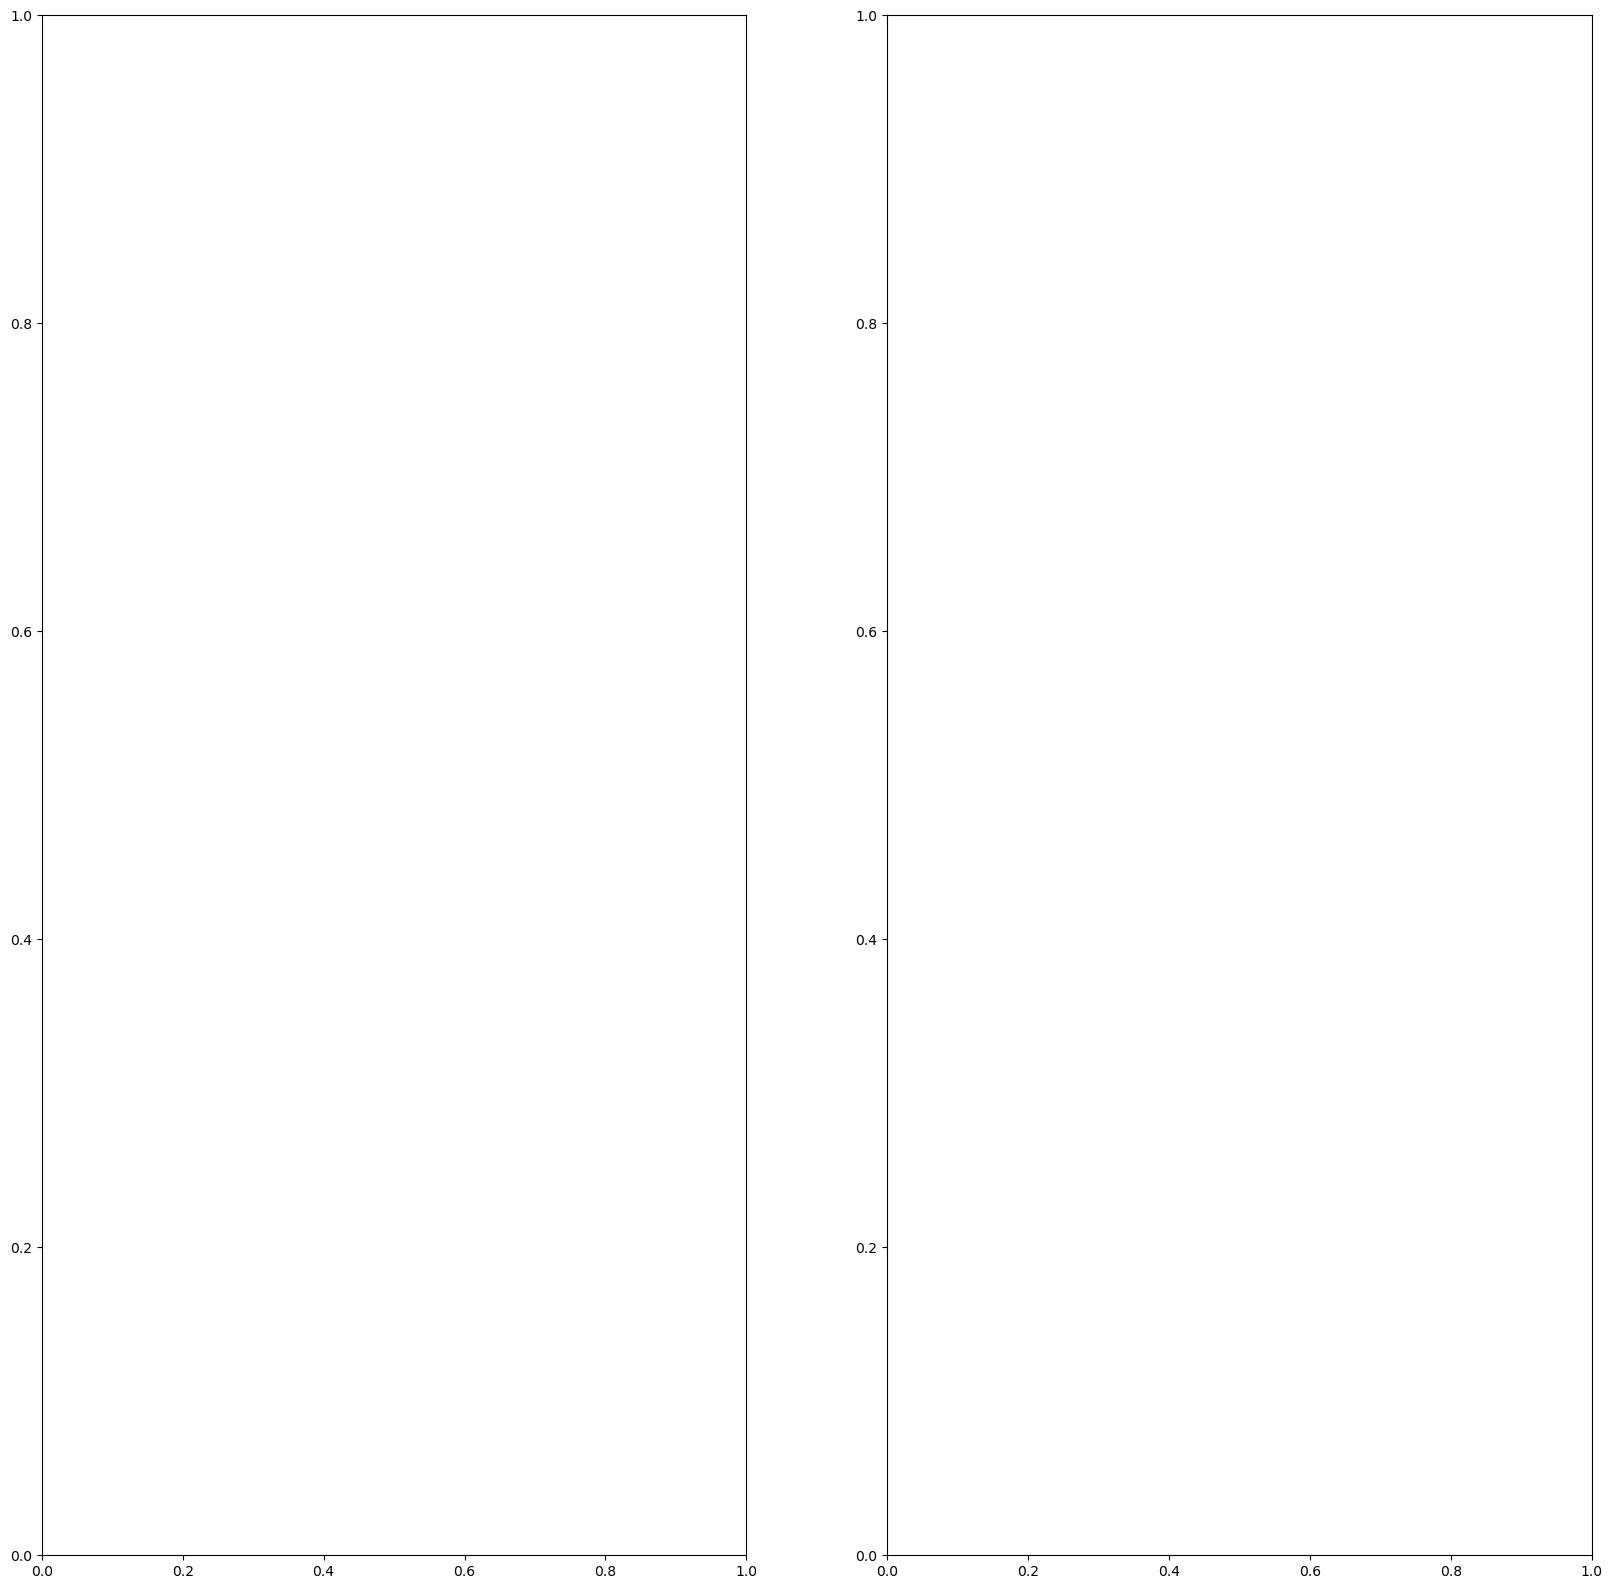

In [4]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=2)

rgb_original = create_rgb(coadds.image, bgr=['g', 'r', 'i'], scale=None)
ax[0].imshow(rgb_original, origin='lower')
ax[0].set_title('original', fontsize=30)

ax[1].set_title('re-scaled', fontsize=30)
rgb_scaled = create_rgb(coadds.image, bgr=['g', 'r', 'i'],
                        scale=[0.6, 0.7, 1.0])
ax[1].imshow(rgb_scaled, origin='lower')

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()
remove_figure(fig)

This calls the Butler to get the coadded data corresponding to the tract and patch we asked for above

In [62]:
#dataId = {'band': 'i', 'tract': 4641, 'patch':37}
my_deepCoadd = butler.get('deepCoadd',dataId=dataId)

#my_calexp = butler.get('calexp',dataId=dataId2)


This makes a plot of the coadded data.

(19899.5, 24099.5, 7899.5, 12099.5)

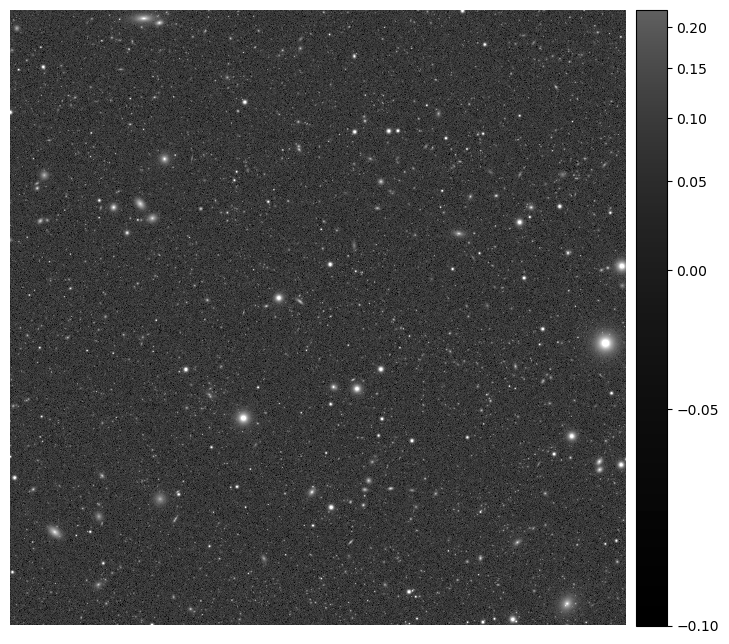

In [63]:
fig = plt.figure(figsize=(10,8))      # create a matplotlib.pyplot figure
afw_display = afwDisplay.Display(1)   # create an alias for the lsst.afw.display.Display() method
afw_display.scale('asinh', 'zscale')  # set the algorithm and scale for the pixel shading
afw_display.mtv(my_deepCoadd.image)   # display the image data you retrieved with the butler
#afw_display.mtv(my_calexp.image) 
plt.gca().axis('off')                 # turn off the x and y axes labels

In [45]:
import numpy as np
print(np.sqrt(1/np.pi))

0.5641895835477563
